In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

iwildcam_2019_fgvc6_path = kagglehub.competition_download('iwildcam-2019-fgvc6')

print('Data source import complete.')


In [ ]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [ ]:
os.listdir('../input')

['reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6']

## 1. Loading the 32x32 dataset

In [ ]:
# The data, split between train and test sets:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [ ]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

## 2. Create Callback for F1 score

In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

## 3. Creating and Training the Model

In [ ]:
batch_size = 64
num_classes = 14
epochs = 200
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
    shuffle=True
)

Train on 176669 samples, validate on 19630 samples
Epoch 1/200
176669/176669 [==============================] - 19s 107us/step - loss: 0.6978 - acc: 0.7827 - val_loss: 0.4934 - val_acc: 0.8414
val_f1: 0.5093 — val_precision: 0.6033 — val_recall: 0.4880
Epoch 2/200
  1088/176669 [..............................] - ETA: 18s - loss: 0.5386 - acc: 0.8392

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


176669/176669 [==============================] - 18s 104us/step - loss: 0.5015 - acc: 0.8378 - val_loss: 0.4024 - val_acc: 0.8680
val_f1: 0.6743 — val_precision: 0.7221 — val_recall: 0.6512
Epoch 3/200
176669/176669 [==============================] - 18s 103us/step - loss: 0.4426 - acc: 0.8552 - val_loss: 0.3604 - val_acc: 0.8812
val_f1: 0.6818 — val_precision: 0.7510 — val_recall: 0.6539
Epoch 4/200
176669/176669 [==============================] - 18s 104us/step - loss: 0.4069 - acc: 0.8660 - val_loss: 0.3329 - val_acc: 0.8912
val_f1: 0.7423 — val_precision: 0.7665 — val_recall: 0.7314
Epoch 5/200
176669/176669 [==============================] - 18s 103us/step - loss: 0.3797 - acc: 0.8740 - val_loss: 0.3196 - val_acc: 0.8962
val_f1: 0.7511 — val_precision: 0.8030 — val_recall: 0.7240
Epoch 6/200
176669/176669 [==============================] - 18s 103us/step - loss: 0.3597 - acc: 0.8803 - val_loss: 0.3027 - val_acc: 0.8995
val_f1: 0.7575 — val_precision: 0.7929 — val_recall: 0.7389
Ep

Save model and weights

In [ ]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/models/keras_cnn_model.h5 


## 4. Evaluation

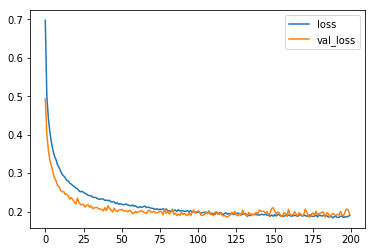

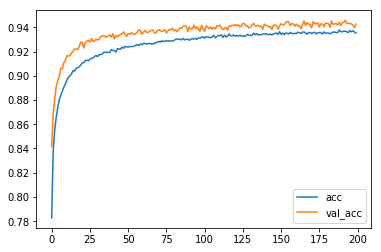

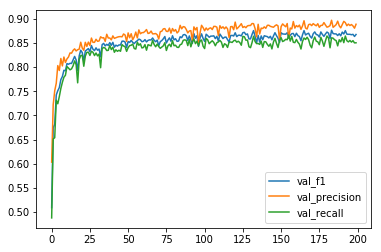

In [ ]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

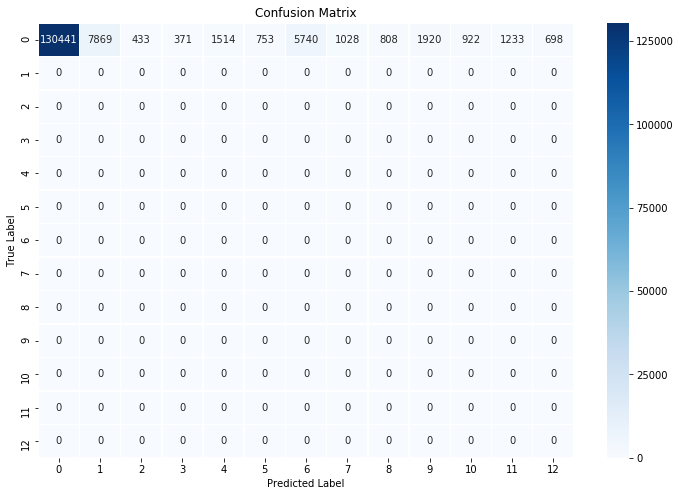

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Number of classes
num_classes = 14

# Get true labels and predictions from the test set
y_test_true = submission_df['Category'].values
y_test_pred = submission_df['Predicted'].values

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedM

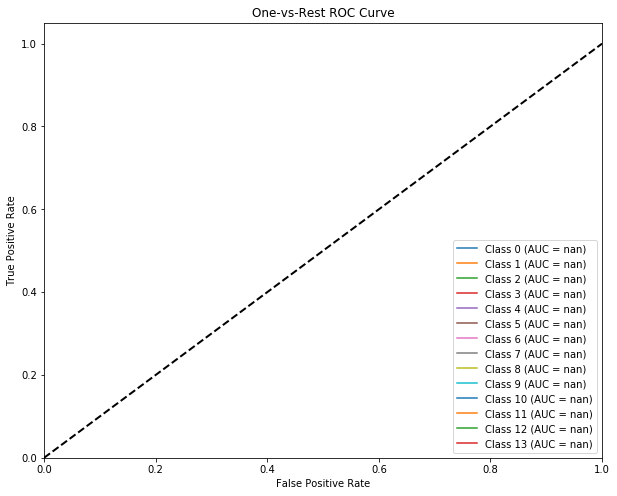

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
# Binarize the true labels for one-vs-rest ROC curve computation
y_test_binarized = label_binarize(y_test_true, classes=np.arange(num_classes))
y_pred_binarized = label_binarize(y_test_pred, classes=np.arange(num_classes))

# Initialize the plot for ROC curve
plt.figure(figsize=(10, 8))

# Loop through each class and plot its ROC curve
for i in range(num_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


## 5. Submission

In [ ]:
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)
print(submission_df.shape)
submission_df.head()

(153730, 4)


,Unnamed: 0,Id,Category,Predicted
0,0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0,0
1,1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0,1
2,2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0,0
3,3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0,0
4,4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0,0


In [ ]:
submission_df.to_csv('submission.csv',index=False)
history_df.to_csv('history.csv', index=False)

with open('history.json', 'w') as f:
    json.dump(hist.history, f)

In [ ]:
!tar -zcvf "{dataset_folder}.tar.gz" /kaggle/working/*

tar: Removing leading `/' from member names
/kaggle/working/history.csv
/kaggle/working/history.json
/kaggle/working/models/
/kaggle/working/models/keras_cnn_model.h5
/kaggle/working/submission.csv
/kaggle/working/{dataset_folder}.tar.gz
tar: /kaggle/working/{dataset_folder}.tar.gz: file changed as we read it
